## Описание

Данный ноутбук является откликом на [вакансию яндекса](https://yandex.ru/jobs/vacancies/proj_man/data_techman/), Задание 2



### Условия задания 2
Формат файла: login tuid docid jud cjud.

Пояснение к формату: login — логин асессора; uid — id асессора (user id); docid — id оцениваемого документа (document id); jud — оценка асессора (judgement); cjud — правильная оценка (correct judgement); разделитель — табуляция \t.

Оценки могут принимать значение [0, 1], т.е. задание, которое сделали асессоры, имеет бинарную шкалу.

Используя данные об оценках, установите, какие асессоры хуже всего справились с заданием. На какие показатели вы ориентировались и какие метрики вы использовали для ответа на этот вопрос? Можно ли предложить какие-то новые метрики для подсчета качества асессоров с учетом природы оценок у этого бинарного задания? 

## Краткие итоги (ответ)

### Какие факты известны?

1. Ответы распределены неравномерно, ставя везде 0 - легко угадать правильный ответ с вероятностью 88% - причем более половины ассесоров отвечают хуже
2. Самое сложное для ассесоров - отвечать на вопросы с положительным ответом - здесь им удается только в половине случаев ответить правильно.
3. Таким образом для оценки ассесора приходится смотреть на верность ответа по взвешенной ошибке среди положительных и отрицательных ответов. 

***Средняя ошибка по всем вопросам конечно тоже подходит, но не раскрывает особенности. Так, почти все лидеры в этой номинации показывают плохой результат с положительными ответами - - 40% из них ошибочны***

### Предлагаемый ответ

#### Какие асессоры хуже всего справились с заданием?
Все, у кого процент ошибочных ответов более 14%. 
*Почему не 12%?* 
Некоторые выполнили бы задание лучше, если бы просто проставили везде ноль. Но человек - не машина, и вопрос в том, сколько лучших нам нужно. Все, у кого ошибка меньше 14% - лучше половины работавших ассесоров - а это уже высокая планка.

#### На какие показатели вы ориентировались и какие метрики вы использовали для ответа на этот вопрос? 
Средняя ошибка по всем вопросам среди всех ассесоров, а также квантили по ней. Квантили по ошибкам среди положительных и отрицательных ответов.

#### Можно ли предложить какие-то новые метрики для подсчета качества асессоров с учетом природы оценок у этого бинарного задания? 
Вообще говоря не так уж и много параметров, чтобы было где разгуляться. Еще можно использовать пересечение по вопросам - выкинуть из расчета документы, где все ассесоры ошиблись как слишком сложные, и выкинуть слишком простые документы, где не ошибся никто. (см. Гипотеза 3)



## Открытые вопросы
1. Есть ли среди ассесоров те, что хорошо отвечают положительные ответы? Т.е. ошибаются там меньше, чем в отрицательных ответах? - Да, у них возможно общая ошибка больше, но возможно что только на положительных ответах они бы показали хороший результат.


## Решение, код и комментарии

### Введение

В начале сделаем обзор данных, в каком они состоянии. Нет ли пропусков, есть ли дубликаты, требуется ли очистить данные от мусора. 

In [24]:
import pandas as pd
import seaborn as sns
df = pd.read_csv('sources/data_task3.csv', sep='\t')
df.head()

,login,uid,docid,jud,cjud
0,assessor158,158,0,0,0
1,assessor238,238,0,0,0
2,assessor488,488,0,0,0
3,assessor136,136,0,0,0
4,assessor300,300,0,0,0


In [31]:
df[df.duplicated(keep=False)]

,login,uid,docid,jud,cjud
82895,assessor306,306,16579,0,0
82899,assessor306,306,16579,0,0


In [3]:
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   login   250000 non-null  object
 1   uid     250000 non-null  int64 
 2   docid   250000 non-null  int64 
 3   jud     250000 non-null  int64 
 4   cjud    250000 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 9.5+ MB


In [4]:
df.describe()

,uid,docid,jud,cjud
count,250000.000000,250000.000000,250000.000000,250000.000000
mean,299.325672,24999.500000,0.238120,0.119920
std,173.131872,14433.785594,0.425934,0.324869
min,0.000000,0.000000,0.000000,0.000000
25%,150.000000,12499.750000,0.000000,0.000000
50%,299.000000,24999.500000,0.000000,0.000000
75%,449.000000,37499.250000,0.000000,0.000000
max,599.000000,49999.000000,1.000000,1.000000


Вроде бы все хорошо. Из последней таблички уже видно, что варианты ответов распределены неравномерно, правильный ответ 1 - встречается всего в 12% вопросов. Также видно, что ассесоры ставят 1 значительно чаще.

## Гипотеза 1.
Первая мысль, которая приходит в голову - посмотреть, насколько часто ошибаются ассесоры и какой средний процент ошибок среди них - какое значение ошибки будет для нормального ассесора?


In [5]:
df['valid'] = (df.jud == df.cjud)
df = df.set_index('login')

In [6]:
df.loc['assessor158']['valid'].value_counts()

True     339
False     45
Name: valid, dtype: int64

In [7]:
errors = df.groupby('login').apply(
    lambda x: (~x['valid']).sum()/x.shape[0]
)

In [8]:
errors.describe()

count    600.000000
mean       0.159342
std        0.055462
min        0.076190
25%        0.112500
50%        0.166667
75%        0.191462
max        0.574209
dtype: float64

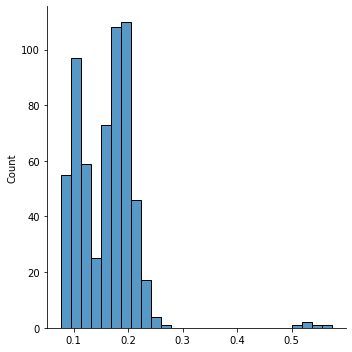

In [9]:
sns.displot(errors);


Видно, что ассесоры часто ошибаются - средний ассесор делает 15% ошибок. Давайте на всякий случай очистим датасет от часто ошибающихся ассесоров и оставим тех, кто показывает хороший результат. Также видно, что есть ассесоры, котрые ставят ответы рандомно))

In [10]:
errors[errors<0.192].describe()

count    454.000000
mean       0.139870
std        0.036061
min        0.076190
25%        0.104781
50%        0.145031
75%        0.174186
max        0.191874
dtype: float64

Стало не сильно лучше - 14%. Зависит ли результат от того, что ассесор ставит в ответ? 

In [11]:
err_01 = df.groupby(['login', 'jud']).apply(
    lambda x: (~x['valid']).sum()/x.shape[0]
).unstack()

In [12]:
err_01.describe()

jud,0,1
count,600.000000,600.000000
mean,0.027107,0.568509
std,0.015418,0.101006
min,0.002882,0.333333
25%,0.017738,0.484604
50%,0.024353,0.588472
75%,0.032117,0.638714
max,0.131429,0.902542


О, это уже интереснее. Похоже, что угадать 1 значительно сложнее, чем 0. Давайте посмотрим как будет ошибаться наивная модель, которая везде ставит 0 (Вроде бы ответа 1 было не так уж и много)

In [13]:
df[['docid', 'cjud']].drop_duplicates()['cjud'].describe()

count    50000.000000
mean         0.119920
std          0.324871
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: cjud, dtype: float64

Опа, правильный ответ 1 всего в 0.12 % случаях.
Нет ли случайно двух одинаковых документов с разными ответами?

In [14]:
df[['docid', 'cjud']].drop_duplicates()['docid'].duplicated().sum()

0

Ну хорошо, а то и такое бывает. 





## Гипотеза 2

Давайте сравним ассесоров с наивной моделью, которая везде ставит наиболее популярный ответ. 

In [15]:
(0.12 - errors).value_counts(bins=[-1,-0.05,0,0.01, 0.05,1])

(-1.001, -0.05]    285
(0.01, 0.05]       136
(-0.05, 0.0]       128
(0.0, 0.01]         51
(0.05, 1.0]          0
dtype: int64

Как видно отсюда, всего 136 (22%)  ассеров справляются лучше, чем наивная модель. Давайте посмотрим еще, может быть некоторые из них лучше угадывают 0, а другие 1? Тогда им можно было бы поручить работу только по тем задачам, где другие ассесоры поставили 1.

Возьмем тех ассесоров, которые показывают хороший результат(По крайней мере не хуже наивной модели) и посмтрим, как они справляются с задачами с положительным ответом

In [16]:
rule = errors<0.12
assessors = errors[rule].index.to_list()

In [17]:
err_01.loc[assessors].sort_values(1)

jud,0,1
login,,
assessor545,0.026882,0.333333
assessor462,0.033058,0.344828
assessor577,0.023460,0.353659
assessor565,0.037249,0.356322
assessor487,0.015432,0.368421
...,...,...
assessor481,0.018750,0.554054
assessor387,0.027548,0.557143
assessor158,0.012862,0.561644


In [18]:
err_01.loc[assessors].describe()

jud,0,1
count,187.000000,187.000000
mean,0.019927,0.450126
std,0.008131,0.046969
min,0.002882,0.333333
25%,0.014368,0.414764
50%,0.018919,0.449275
75%,0.025215,0.481705
max,0.046154,0.608108


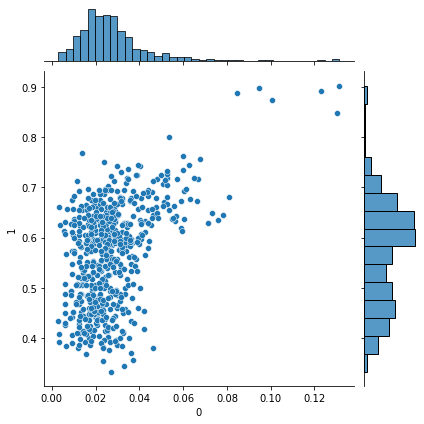

In [19]:
sns.jointplot(x=err_01[0], y=err_01[1])

Как видно, ассесоры есть разные, кто-то хорошо справляется с обоими вариантами ответов, а кто-то в сомнительных случаях ставит нолик или 1, что больше нравится) Отсюда приходится сделать вывод, что ассесоров придется оценивать по величине ошибке в обоих колонках. Посмотрим, сколько ассесоров показывают результаты в таком случае лучше среднего.

In [20]:
xx = err_01.loc[assessors]
rule = xx[0]<0.02
rule &= xx[1]<0.45


In [21]:
x3 = xx[rule]
(x3[1]<0.4).sum()

10

In [22]:
xx.join(errors.rename('sum')).sort_values('sum').head()

,0,1,sum
login,,,
assessor296,0.016901,0.400000,0.076190
assessor545,0.026882,0.333333,0.076577
assessor184,0.009009,0.405797,0.077114
assessor63,0.014577,0.409091,0.078240
assessor191,0.012285,0.428571,0.078512


In [23]:
xx[rule].join(errors.rename('sum')).sort_values(1).head()

,0,1,sum
login,,,
assessor487,0.015432,0.368421,0.095465
assessor151,0.011730,0.379747,0.080952
assessor82,0.006309,0.383721,0.086849
assessor240,0.017341,0.385417,0.097285
assessor591,0.012384,0.387097,0.096154


In [24]:
xx[rule].join(errors.rename('sum')).sort_values('sum').head()

,0,1,sum
login,,,
assessor296,0.016901,0.400000,0.076190
assessor184,0.009009,0.405797,0.077114
assessor63,0.014577,0.409091,0.078240
assessor191,0.012285,0.428571,0.078512
assessor450,0.003096,0.407895,0.080201


Как видим, самый лучший решатель положительных(1) вопросов не является лучшим в среднем. А что будет, если мы возьмем его и проверим ответами из лучшего по нулевым вопросам?


In [25]:
xx[rule].join(errors.rename('sum')).sort_values(0).head()

,0,1,sum
login,,,
assessor458,0.002882,0.434343,0.098655
assessor450,0.003096,0.407895,0.080201
assessor259,0.003135,0.391304,0.090024
assessor162,0.005865,0.426966,0.093023
assessor38,0.005900,0.430556,0.080292


In [26]:
jud0 = df.loc['assessor259'].set_index('docid')['jud']
jud1 = df.loc['assessor487'].set_index('docid')
cjud = jud1['cjud']
pd.concat([jud0, jud1['jud'], cjud], axis=1, keys=[1,2,3]).dropna()

,1,2,3
docid,,,
40772,1.0,1.0,1.0
43631,1.0,1.0,1.0


А ничего, потому что документы между ассесорами слабо пересекаются. Каждый документ дублируется всего 5 раз.

In [27]:
df['docid'].value_counts().sort_values().describe()

count    50000.0
mean         5.0
std          0.0
min          5.0
25%          5.0
50%          5.0
75%          5.0
max          5.0
Name: docid, dtype: float64

## Гипотеза 3

А давайте выкинем все самые сложные и самые простые документы и посмотрим, как изменится картина в таком случае?

In [20]:
df.groupby('docid')['valid'].sum().value_counts()

5    21086
4    19793
3     7603
2     1397
1      117
0        4
Name: valid, dtype: int64

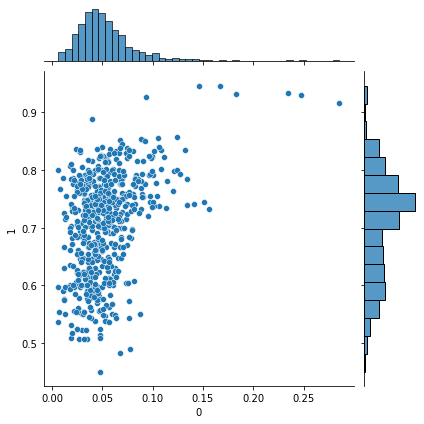

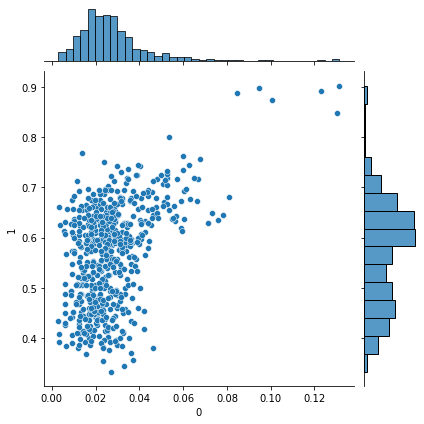

In [22]:
a = df.groupby('docid')['valid'].sum()
simple_documents = a[a.isin([5,1,0])].index.to_list()

rule = ~df['docid'].isin(simple_documents)

df2 = df[rule]

err2_01 = df2.groupby(['login', 'jud']).apply(
    lambda x: (~x['valid']).sum()/x.shape[0]
).unstack()
sns.jointplot(x=err2_01[0], y=err2_01[1]) # новый график
sns.jointplot(x=err_01[0], y=err_01[1]) # выведем старый график рядом для сравнения